# Rozpoznawanie pisanych liter 

In [28]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

![alt](https://raw.githubusercontent.com/przem85/bootcamp/master/introduction/img/mnist_originals.png)

MNIST to baza danych odręcznie napisanych cyfr około 20 lat temu. Ludzie są w stanie rozpoznać ok. 99,5% cyfr z tego zbioru poprawnie. Zobaczymy ile nam się uda!

In [4]:
img = mnist.data[0]
print("Pierwsz obrazek z ", mnist.data.shape[0], ":", img) # Pixele

Pierwsz obrazek z  70000 : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253

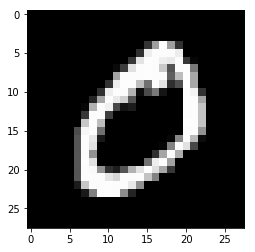

In [5]:
# Możemy sobie narysować wcześniej wypisaną cyfrę
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(img.reshape(28,28), cmap="gray")

In [7]:
import sklearn
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import numpy as np

## Krok 1: wczytanie i podzielenie danych

In [29]:
#Wczytujemy dane i skalujemy
X, Y = mnist.data.astype("float64"), mnist.target 
X = preprocessing.scale(X)

In [30]:
#Dzielimy na dane trenujące i testujące
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

## Krok 2: dopasujmy pare modeli - uwaga! To juz trwa chwile, 70000 przykladow o 784 cechach kazdy.

In [31]:
# Na wszystkich przykladach osiaga 92% dokladnosci. 
N = 500 # Podzbiór danych
model = LogisticRegression() # Model z domyślnymi parametrami
model.fit(X_train[0:N], Y_train[0:N])

Y_test_predicted = model.predict(X_test)
print("Dokładność modelu wytrenowanego na ",N, " przykladach to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%")

Dokładność modelu wytrenowanego na  500  przykladach to:  78.8571428571 %


## Przyklad zaklasyfikowany jako

Przyklad zaklasyfikowany jako  [ 0.]


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


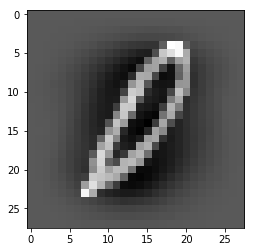

In [34]:
print("Przyklad zaklasyfikowany jako ", model.predict(X_test[2]))
plt.imshow(X_test[2].reshape(28,28), cmap="gray")

## Krok 3: Tworzymy caly model zmniejszając ilość przykładów
W scikit-learn możemy połączyć pare modeli w **pipeline**, który sam implementuje interfejs Estimator.

In [35]:
pca = decomposition.PCA(n_components=20)
pca.fit(X_train)
X_train_transf = pca.transform(X_train)

In [36]:
logistic = linear_model.LogisticRegression(C=0.1)
logistic.fit(X_train_transf, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [38]:
#Zobaczmy na dokładność modelu
Y_test_predicted = pipe.predict(X_test)
print("Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%")

Dokładność modelu wytrenowanego to:  84.9028571429 %


**Poprawa o 6%! Nice**

## Poszukajmy najlepszych hiperparametrów

In [40]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'pca__n_components':[10,20,30], 'logistic__C':  [1, 10, 100, 1000]}]
clf_fitted = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
clf = GridSearchCV(clf_fitted, tuned_parameters, cv=5, scoring='accuracy', verbose=4)
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.779608 -   7.2s
[CV] logistic__C=1, pca__n_components=10 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] .... logistic__C=1, pca__n_components=10, score=0.776233 -   7.0s
[CV] logistic__C=1, pca__n_components=10 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] .... logistic__C=1, pca__n_components=10, score=0.779735 -   7.2s
[CV] logistic__C=1, pca__n_components=10 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.8s remaining:    0.0s


[CV] .... logistic__C=1, pca__n_components=10, score=0.776741 -   7.3s
[CV] logistic__C=1, pca__n_components=10 .............................
[CV] .... logistic__C=1, pca__n_components=10, score=0.780827 -   7.4s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.846249 -  12.7s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.853171 -  12.3s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.850300 -  12.9s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.851319 -  12.7s
[CV] logistic__C=1, pca__n_components=20 .............................
[CV] .... logistic__C=1, pca__n_components=20, score=0.852964 -  13.1s
[CV] logistic__C=1, pca__n_components=30 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'pca__n_components': [10, 20, 30], 'logistic__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=4)

In [41]:
clf.best_estimator_

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [42]:
#Zobaczmy na dokładność modelu
Y_test_predicted = clf.best_estimator_.predict(X_test)
print("Dokładność modelu wytrenowanego to: ",100*sklearn.metrics.accuracy_score(Y_test, Y_test_predicted), "%")

Dokładność modelu wytrenowanego to:  87.2057142857 %
